- E01: I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

words = open('names.txt', 'r').read().splitlines()
print(words[:8])
len(words)

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


32033

In [2]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [3]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


Initialize to zeros 

In [8]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.zeros((vocab_size, n_embd))
W1 = torch.zeros((n_embd * block_size, n_hidden)) 
b1 = torch.randn(n_hidden) 
W2 = torch.zeros((n_hidden, vocab_size))
b2 = torch.zeros(vocab_size)

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


In [10]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # # BatchNorm layer
  # # -------------------------------------------------------------
  # bnmeani = hpreact.mean(0, keepdim=True)
  # bnstdi = hpreact.std(0, keepdim=True)
  # hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  # with torch.no_grad():
  #   bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
  #   bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.0750
  10000/ 200000: 3.1653
  20000/ 200000: 2.8782
  30000/ 200000: 2.7193
  40000/ 200000: 2.8201
  50000/ 200000: 2.9472
  60000/ 200000: 2.8085
  70000/ 200000: 2.8959
  80000/ 200000: 2.7585
  90000/ 200000: 2.8682
 100000/ 200000: 2.5144
 110000/ 200000: 2.6327
 120000/ 200000: 2.8720
 130000/ 200000: 2.9990
 140000/ 200000: 2.7046
 150000/ 200000: 2.9978
 160000/ 200000: 3.3526
 170000/ 200000: 2.6795
 180000/ 200000: 2.7337
 190000/ 200000: 2.8824


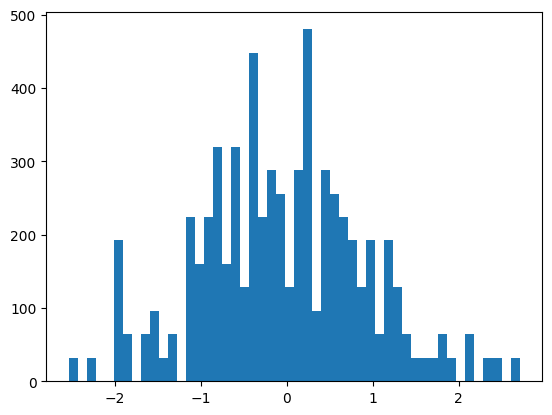

In [11]:
plt.hist(hpreact.view(-1).tolist(), 50);

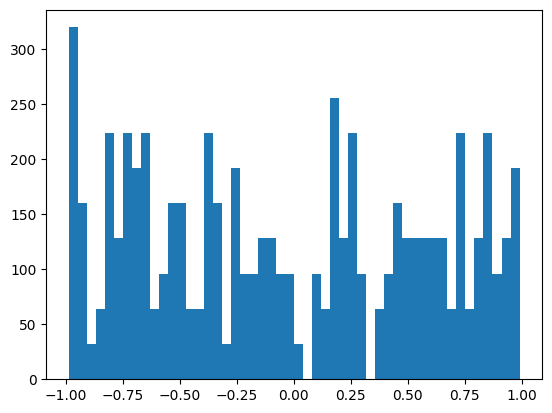

In [12]:
plt.hist(h.view(-1).tolist(), 50);

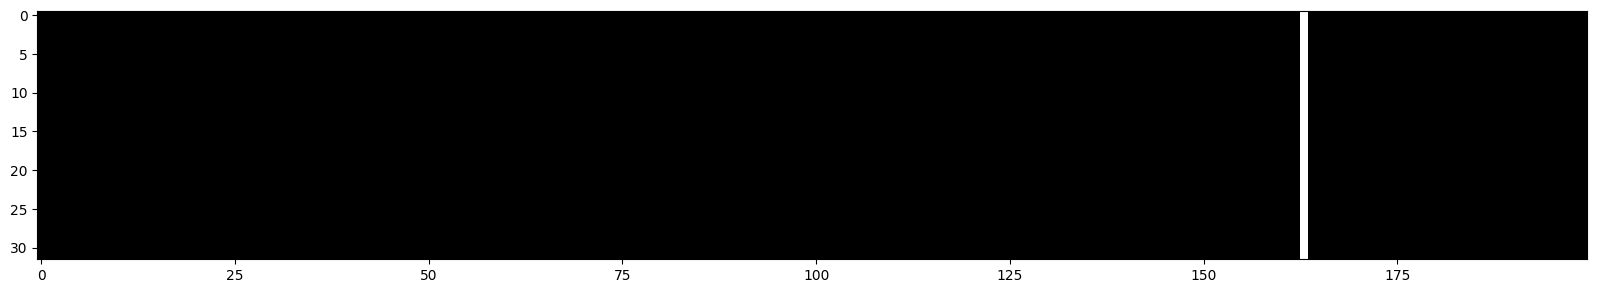

In [13]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

# x-axis: neurons
# y-axis: examples

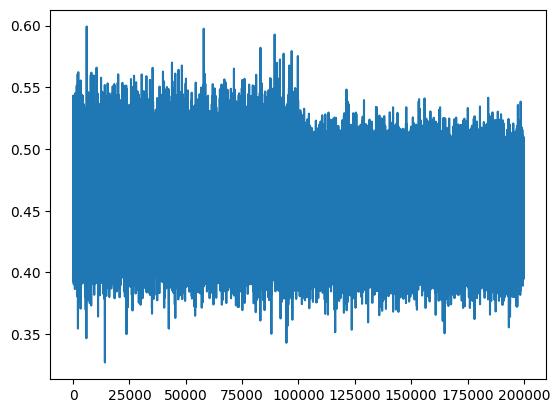

In [14]:
plt.plot(lossi)

In [15]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1  + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.8317830562591553
val 2.830718755722046


In [33]:
## Pytorchifying 

In [34]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.zeros((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.zeros((vocab_size, n_embd),            )
layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]


parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46497


In [35]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  # if i >= 1000:
  #   break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2958
  10000/ 200000: 2.7441
  20000/ 200000: 2.8786
  30000/ 200000: 2.8612
  40000/ 200000: 2.7905
  50000/ 200000: 2.8820
  60000/ 200000: 2.8168
  70000/ 200000: 2.4080
  80000/ 200000: 2.7652
  90000/ 200000: 2.8202
 100000/ 200000: 2.8007
 110000/ 200000: 2.6733
 120000/ 200000: 2.8301
 130000/ 200000: 2.5750
 140000/ 200000: 2.8865
 150000/ 200000: 2.9302
 160000/ 200000: 2.8705
 170000/ 200000: 2.5972
 180000/ 200000: 3.1449
 190000/ 200000: 2.6769


In [36]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.822678327560425
val 2.8210480213165283


In [37]:
# Inspect the gradients and activations to figure out what is happening and why the network is only partially training, 
# and what part is being trained exactly.

In [38]:
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

layer 1 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

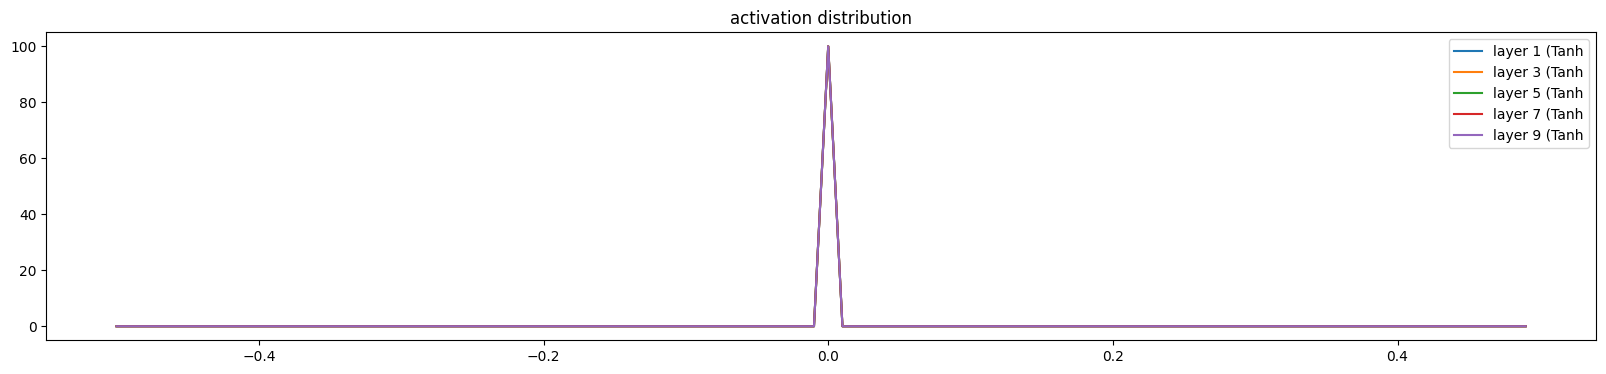

In [41]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

In [42]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

AttributeError: 'NoneType' object has no attribute 'mean'

<Figure size 2000x400 with 0 Axes>

weight   (27, 10) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight  (30, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight  (100, 27) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan


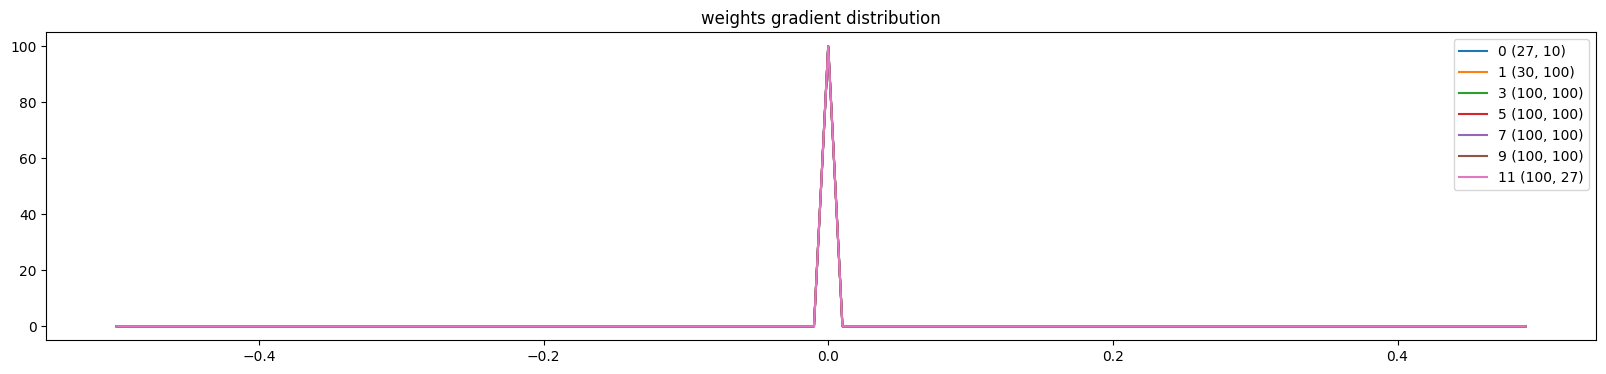

In [43]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

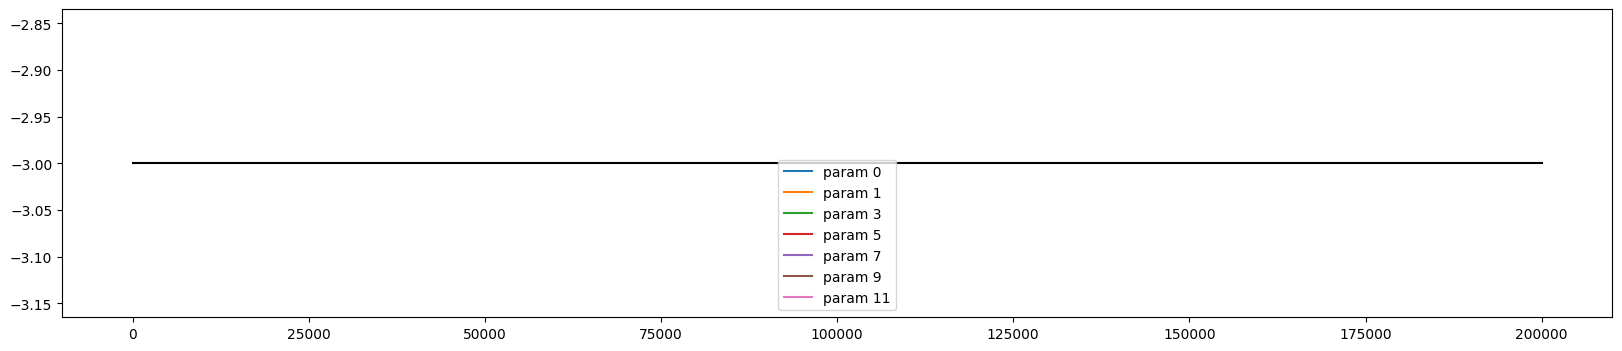

In [44]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


-The issue is likely due to initializing all weights and biases to zero. When weights are zero, all neurons in a layer produce the same output, causing identical gradients to propagate back, and no learning occurs in earlier layers. Only the last layer may show some activity since gradients might propagate there.

-To fix this, use a proper weight initialization (e.g., Xavier or He initialization) to break symmetry and allow all layers to learn. After doing this, running the full optimization before inspecting activations and gradients will give more insight into the training process.

- E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

In [45]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Hyperparameters
n_embd = 10        # Dimensionality of character embeddings
n_hidden = 100     # Number of neurons in hidden layers
block_size = 3     # Context length (number of previous characters)
vocab_size = 27    # Number of unique characters (as an example)

# Initialize parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)

# First Linear Layer
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) / (n_embd * block_size)**0.5
b1 = torch.zeros(n_hidden)

# BatchNorm parameters for Layer 1
gamma1 = torch.ones(n_hidden)
beta1 = torch.zeros(n_hidden)
bn_mean1 = torch.zeros(n_hidden)
bn_var1 = torch.ones(n_hidden)

# Second Linear Layer
W2 = torch.randn((n_hidden, n_hidden), generator=g) / n_hidden**0.5
b2 = torch.zeros(n_hidden)

# BatchNorm parameters for Layer 2
gamma2 = torch.ones(n_hidden)
beta2 = torch.zeros(n_hidden)
bn_mean2 = torch.zeros(n_hidden)
bn_var2 = torch.ones(n_hidden)

# Output Layer
W3 = torch.randn((n_hidden, vocab_size), generator=g) / n_hidden**0.5
b3 = torch.zeros(vocab_size)

# Collect all parameters
parameters = [C, W1, b1, gamma1, beta1, W2, b2, gamma2, beta2, W3, b3]
for p in parameters:
    p.requires_grad = True

# # Dummy training data (replace with actual data)
# Xtr = torch.randint(0, vocab_size, (1000, block_size), generator=g)
# Ytr = torch.randint(0, vocab_size, (1000,), generator=g)

# Training loop
max_steps = 5000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    emb = C[Xb]                         # Embedding layer
    embcat = emb.view(emb.shape[0], -1)
    
    # Layer 1
    hpre1 = embcat @ W1 + b1
    bn_mean1_batch = hpre1.mean(0)
    bn_var1_batch = hpre1.var(0, unbiased=False) + 1e-5
    hpre1_norm = (hpre1 - bn_mean1_batch) / torch.sqrt(bn_var1_batch)
    hpre1_bn = gamma1 * hpre1_norm + beta1
    h1 = torch.tanh(hpre1_bn)
    
    # Update running mean and var
    with torch.no_grad():
        bn_mean1 = 0.9 * bn_mean1 + 0.1 * bn_mean1_batch
        bn_var1 = 0.9 * bn_var1 + 0.1 * bn_var1_batch
    
    # Layer 2
    hpre2 = h1 @ W2 + b2
    bn_mean2_batch = hpre2.mean(0)
    bn_var2_batch = hpre2.var(0, unbiased=False) + 1e-5
    hpre2_norm = (hpre2 - bn_mean2_batch) / torch.sqrt(bn_var2_batch)
    hpre2_bn = gamma2 * hpre2_norm + beta2
    h2 = torch.tanh(hpre2_bn)
    
    # Update running mean and var
    with torch.no_grad():
        bn_mean2 = 0.9 * bn_mean2 + 0.1 * bn_mean2_batch
        bn_var2 = 0.9 * bn_var2 + 0.1 * bn_var2_batch
    
    # Output layer
    logits = h2 @ W3 + b3
    loss = F.cross_entropy(logits, Yb)
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update parameters
    lr = 0.1
    for p in parameters:
        p.data -= lr * p.grad
    
    # Record loss
    if i % 500 == 0:
        print(f'Step {i}/{max_steps}, Loss: {loss.item():.4f}')
    lossi.append(loss.item())

# Function to perform forward pass (with BatchNorm)
def forward_with_bn(X):
    emb = C[X]
    embcat = emb.view(emb.shape[0], -1)
    hpre1 = embcat @ W1 + b1
    hpre1_norm = (hpre1 - bn_mean1) / torch.sqrt(bn_var1 + 1e-5)
    hpre1_bn = gamma1 * hpre1_norm + beta1
    h1 = torch.tanh(hpre1_bn)
    hpre2 = h1 @ W2 + b2
    hpre2_norm = (hpre2 - bn_mean2) / torch.sqrt(bn_var2 + 1e-5)
    hpre2_bn = gamma2 * hpre2_norm + beta2
    h2 = torch.tanh(hpre2_bn)
    logits = h2 @ W3 + b3
    return logits

# Fold BatchNorm parameters into preceding Linear layers
with torch.no_grad():
    # For Layer 1
    std1 = torch.sqrt(bn_var1 + 1e-5)
    W1_folded = (gamma1 / std1).unsqueeze(0) * W1
    b1_folded = (gamma1 / std1) * (b1 - bn_mean1) + beta1
    
    # For Layer 2
    std2 = torch.sqrt(bn_var2 + 1e-5)
    W2_folded = (gamma2 / std2).unsqueeze(0) * W2
    b2_folded = (gamma2 / std2) * (b2 - bn_mean2) + beta2

# Function to perform forward pass (without BatchNorm)
def forward_without_bn(X):
    emb = C[X]
    embcat = emb.view(emb.shape[0], -1)
    hpre1_folded = embcat @ W1_folded + b1_folded
    h1 = torch.tanh(hpre1_folded)
    hpre2_folded = h1 @ W2_folded + b2_folded
    h2 = torch.tanh(hpre2_folded)
    logits = h2 @ W3 + b3
    return logits

# Verify that outputs are the same
X_test = Xtr[:5]  # Sample input for testing
logits_bn = forward_with_bn(X_test)
logits_folded = forward_without_bn(X_test)
difference = (logits_bn - logits_folded).abs().max().item()
print(f'Maximum difference between outputs: {difference:.6f}')


Step 0/5000, Loss: 3.5507
Step 500/5000, Loss: 2.6713
Step 1000/5000, Loss: 2.5356
Step 1500/5000, Loss: 2.3257
Step 2000/5000, Loss: 2.6089
Step 2500/5000, Loss: 2.3084
Step 3000/5000, Loss: 2.4461
Step 3500/5000, Loss: 2.3141
Step 4000/5000, Loss: 2.5246
Step 4500/5000, Loss: 1.7885
Maximum difference between outputs: 0.000001
